# LTSM model

In [1]:
import yfinance as yf
import pandas as pd
import datetime
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras import Sequential,Input
from keras.layers import LSTM,Dense,Bidirectional,Conv1D
import matplotlib.pyplot as plt

In [2]:
# Check GPU availability and enable memory growth
def configureHardware():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"GPUs available: {len(gpus)}")
        for gpu in gpus:
            print(f"GPU: {gpu}")
            # Enable memory growth for each GPU
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except RuntimeError as e:
                print(f"Error setting memory growth: {e}")
    else:
        print("No GPUs found, using CPU.")

    # Use mixed precision for faster training on GPUs (Optional)
    try:
        set_global_policy('mixed_float16')
        print("Mixed precision enabled.")
    except Exception as e:
        print(f"Mixed precision not supported: {e}")

In [3]:
# Function to get the stock's first listing date on market
def stockListingDate(stockName):
    # Download the historical stock data
    stock = yf.Ticker(stockName)
    # Get the historical data for the stock (fetching the max period to get the earliest available data)
    hist_data = stock.history(period="max")
    
    # Check if historical data is available
    if not hist_data.empty:
        # Get the first available date in the historical data
        listing_date = hist_data.index[0].date()
        return str(listing_date)
    else:
        return f"No historical data available for {stockName}"
    

#returns todays date
def todayDate():
    return datetime.datetime.now().strftime('%Y-%m-%d')


# downloads stock data from Yahoo Finance using yfinance library
def downloadStockData(stock: str) -> pd.DataFrame:
    try:
        df = yf.download(stock, start=stockListingDate(stock), end=todayDate())
        if df.empty:
            raise ValueError(f"No data available for {stock}")
        return df
    except Exception as e:
        print(f"Error downloading data for {stock}: {e}")
        return pd.DataFrame()


In [4]:
def cleanData(data: pd.DataFrame) -> pd.DataFrame:
    # Remove missing values
    data.dropna(inplace=True)

    # Convert data types
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])
    data['Open'] = pd.to_numeric(data['Open'])
    data['High'] = pd.to_numeric(data['High'])
    data['Low'] = pd.to_numeric(data['Low'])
    data['Close'] = pd.to_numeric(data['Close'])
    data['Adj Close'] = pd.to_numeric(data['Adj Close'])
    data['Volume'] = pd.to_numeric(data['Volume'])

    # Remove unnecessary columns
    data.drop(['Adj Close'], axis=1, inplace=True)

    # Calculate daily returns
    data['Return'] = data['Close'].pct_change()

    # Calculate moving averages
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()

    # Calculate exponential moving averages
    data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
    data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()
    data['MA_20'] = data['Close'].rolling(window=20).mean()

    # Calculate Relative Strength Index (RSI)
    delta = data['Close'].diff()
    up_days = delta.copy()
    up_days[delta <= 0] = 0
    down_days = abs(delta.copy())
    down_days[delta > 0] = 0
    RS_up = up_days.ewm(com=13, adjust=False).mean()
    RS_down = down_days.ewm(com=13, adjust=False).mean()
    data['RSI'] = 100 - (100 / (1 + RS_up / RS_down))

    # Calculate Bollinger Bands
    data['Upper_BB'] = data['MA_20'] + 2*data['Close'].rolling(window=20).std()
    data['Lower_BB'] = data['MA_20'] - 2*data['Close'].rolling(window=20).std()

    # Remove rows with missing values
    data.dropna(inplace=True)
    
    data = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'MA_20', 'RSI', 'Upper_BB', 'Lower_BB']]

    return data



In [5]:
def prepareData(data:pd.DataFrame):
    trainingDataLen = math.ceil(len(data) * 0.9)
    dataset = data.values
    scaler = MinMaxScaler() # or can use StandardScaler()
    scaledData = scaler.fit_transform(dataset)
    trainData  = scaledData[:trainingDataLen]
    xTrain, yTrain = [], []
    for i in range(100, len(trainData)):
        xTrain.append(trainData[i-100:i, 0])
        yTrain.append(trainData[i, 0])
    
    xTrain = np.array(xTrain).reshape(-1, 100, 1)
    yTrain = np.array(yTrain)
    return xTrain, yTrain, scaler, scaledData, data

In [6]:
def prepareTestData(scaledData: np.ndarray, data:pd.DataFrame):
    trainingDataLen = math.ceil(len(data) * 0.9)
    testData  = scaledData[trainingDataLen -100:]
    xTest, yTest = [], []
    for i in range(100, len(testData)):
        xTest.append(testData[i-100:i, 0])
    
    xTest = np.array(xTest).reshape(-1, 100, 1)
    yTest = testData[100:, 0]  
    
    return xTest, yTest


In [7]:
def buildModel(inputShape:tuple):
    model = Sequential()
    model.add(Input(shape=inputShape))
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(LSTM(100, return_sequences=False, dropout=0.2))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'accuracy', 'precision']) 
    return model

In [8]:
def evaluateModel(xTest, yTest, model):
    loss, mse, accuracy, precision = model.evaluate(xTest, yTest)
    print(f"Loss: {loss}, MSE: {mse}, Accuracy: {accuracy}, Precision: {precision}")


In [9]:
def predict(xTest, model,scaledData,scaler):
    predictions = model.predict(xTest)
    predictions = predictions.reshape(-1, 1)
    dummy_data = np.zeros((predictions.shape[0], scaledData.shape[1]))  
    dummy_data[:, -1] = predictions[:, 0]
    predictions = scaler.inverse_transform(dummy_data)[:,-1]
    return predictions

In [10]:
def nextDayPrediction(data:pd.DataFrame, model, scaler):
    last100Days = data[-100:].values
    last100Days = scaler.transform(last100Days)
    x = np.array(last100Days).reshape(-1, 100, 1)
    prediction = model.predict(x)
    prediction = prediction.reshape(-1, 1)
    dummy_data = np.zeros((prediction.shape[0], data.shape[1]))  
    dummy_data[:, -1] = prediction[:, 0]
    prediction = scaler.inverse_transform(dummy_data)[:,-1]
    return prediction

In [11]:
def plotPredictions(data:pd.DataFrame,prediction:np.ndarray):
    trainingDataLen = math.ceil(len(data) * 0.9)
    train = data[:trainingDataLen]
    valid = data[trainingDataLen:].copy()
    valid.loc[:,'Predictions'] = prediction
    plt.figure(figsize=(16, 8))
    plt.title('Model Predictions vs Actual Prices', fontsize=20)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'], label='Training Data', color='blue', linestyle='solid', linewidth=2)
    plt.plot(valid['Close'], label='Actual Prices', color='green', linestyle='solid', linewidth=2)
    plt.plot(valid['Predictions'], label='Predicted Prices', color='red', linestyle='solid', linewidth=2)
    plt.legend(loc='lower right', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()
    

In [12]:
def main(stock):
    configureHardware()
    downloadedData = downloadStockData(stock)
    cleanedData = cleanData(downloadedData)
    xTrain, yTrain, scaler, scaledData, data = prepareData(cleanedData)
    xTest, yTest = prepareTestData(scaledData, data)   
    model = buildModel(xTrain.shape[1:])
    model.fit(xTrain, yTrain, epochs=10, batch_size=32)
    evaluateModel(xTest, yTest, model)
    predictions = predict(xTest, model, scaledData, scaler)
    nextDayPredict = nextDayPrediction(data, model, scaler)
    print(f"Next day prediction: {nextDayPredict}")
    plotPredictions(data, predictions)
    
    

No GPUs found, using CPU.
Mixed precision enabled.


[*********************100%***********************]  1 of 1 completed


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 1.7864e-04 - loss: 0.0132 - mse: 0.0132 - precision: 0.9684
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - accuracy: 8.1795e-05 - loss: 0.0021 - mse: 0.0021 - precision: 1.0000
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - accuracy: 3.6495e-04 - loss: 0.0017 - mse: 0.0017 - precision: 1.0000
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - accuracy: 2.9051e-04 - loss: 0.0018 - mse: 0.0018 - precision: 1.0000
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.0014 - loss: 0.0012 - mse: 0.0012 - precision: 1.0000
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - accuracy: 7.2622e-04 - loss: 0.0016 - mse: 0.0016 - precision: 1.0000
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 7.9567e-04 - loss: 9.6553e-04 - mse: 9.6542e-04 - precision: 1.0000
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 2.1454e-05 - loss: 5.2991e-04 - mse: 5.3004e-04 - precis

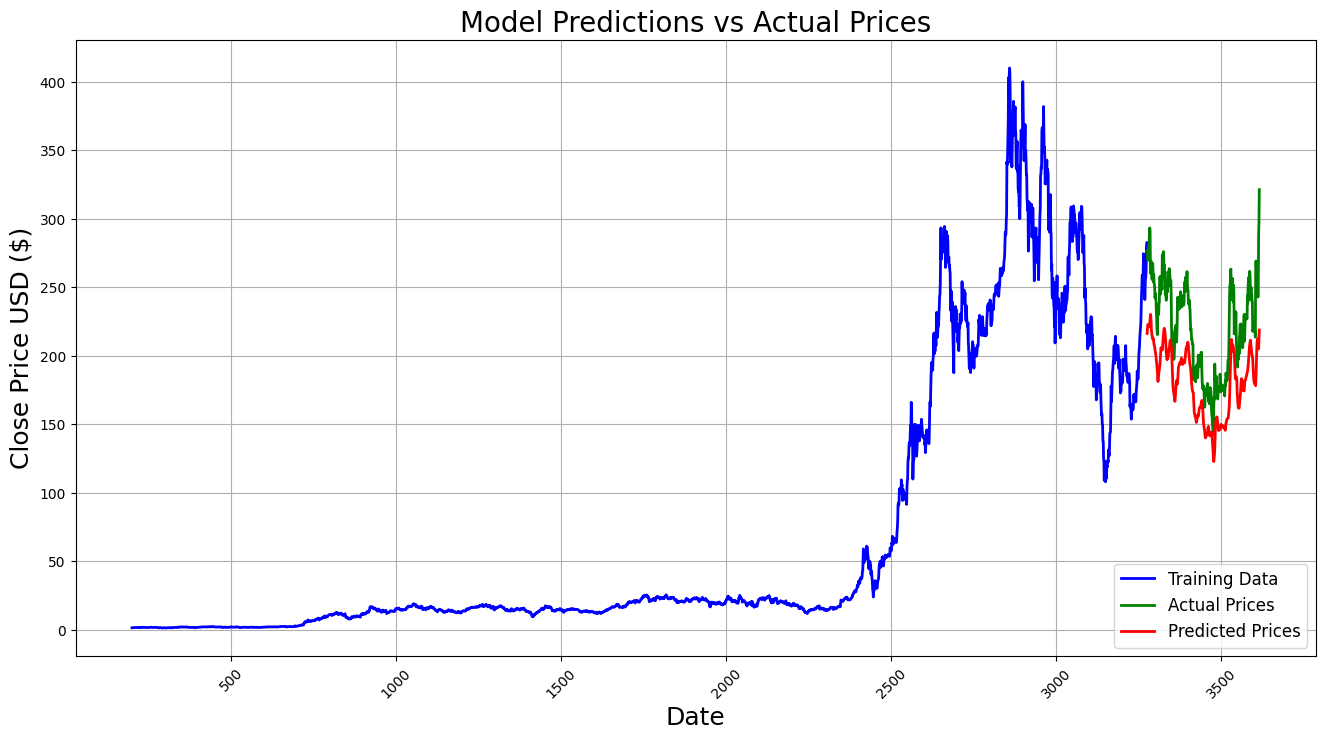

In [13]:
main("TSLA")